# Artificial Neural Network for stable points

## Import libraries and preprocessing

In [2]:
# read & manipulate data
import keras_tuner as kt
import os
import numpy as np
import pandas as pd 
import random as rn
import sys
sys.path.append("../scripts")
import tensorflow as tf
import utils

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.set_visible_devices([], 'GPU') # Disable GPU since slow on my machine
tf.config.threading.set_inter_op_parallelism_threads(8)

In [3]:
# Model paths
pkl_path = '/Users/junxingli/Desktop/master_thesis/data/processed/SRD_Lysekil.pkl'
tuner_path = '/Users/junxingli/Desktop/master_thesis/models/ann/'
proj_name = 'whole_data_shuffled_7_feats-V1/'
best_model_path = tuner_path + proj_name + 'best_model'

# Figure paths
overwrite = False
figs_path = '/Users/junxingli/Desktop/master_thesis/figs/ann/'
plots_path = figs_path + proj_name

In [4]:
def create_sequences(X, y, time_steps):
    ts = X['Time'].values[time_steps:]
    X = X.drop('Time', axis=1).values
    y = y.drop('Time', axis=1).values

    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(np.hstack([X[i:(i+time_steps)], y[i:(i+time_steps)]]))
        ys.append(y[i+time_steps])

    return np.array(Xs), np.array(ys).reshape(-1, 1), np.array(ts)

def run_preprocessing(case='whole_data', sfs=False):
    """
    Function to preprocess the data for the ANN model. Set case to 
    'whole_data' to use the whole dataset, anything else for only stable data.
    Note that sfs_feats can be used after the optimal features has been
    retreived from the SFS algorithm.
    """
    df = pd.read_pickle("../data/processed/SRD_Lysekil.pkl")
    
    if case == "only_stable":
        df = df[df['Status'] == 'Stable']

    sfs_feats = ['T2', 'D8', 'B12', 'T3', 'T10', 'D1', 'F1']
    if sfs == True:
        X = df[sfs_feats + ['Time']]
    else:
        X = df.drop(['Status', 'SRD'], axis=1)
        
    y = df[['Time', 'SRD']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    # Standard scaling the data
    scaler = StandardScaler()
    cols = [col for col in X_train.columns if col != 'Time']
    X_train[cols] = scaler.fit_transform(X_train[cols])
    X_test[cols] = scaler.transform(X_test[cols])

    # Need to reshape since the scaler expects a 2D array
    y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
    y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))

    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler = run_preprocessing(case='whole_data', sfs=True)

input_dim = X_train.shape[-1] - 1
output_dim = y_train.shape[-1] - 1

# Hyperband with ANN [Interpolation] 

WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


If you get a error similar to this:

"ValueError: Received incompatible tensor with shape (75,) when attempting to restore variable with shape (50,) and name dense/bias:0."

then just change the number of nodes to the one in the error message. This bug happens due to MyHyperModel()

In [5]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp): 
        hp_layers = hp.Int('num_layers', 3, 5)
        #hp_normal = hp.Boolean('normalization', default=False)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'])
            
        model = keras.Sequential()
        model.add(Input(shape=(input_dim,)))
        for i in range(hp_layers):
            hp_nodes = hp.Int('num_nodes_'+str(i), min_value=75, max_value=150, step=5)
            hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
            hp_dropout = hp.Boolean('dropout-normalization', default=False)
            
            model.add(Dense(units=hp_nodes, activation=hp_activation))
            if hp_dropout:
                model.add(Dropout(rate=0.25))
                model.add(BatchNormalization())
        
        model.add(Dense(1, activation='linear'))
        
        # Select optimizer    
        optimizer_dict = {
            'adam': keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
            'SGD': keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate),
            'rmsprop': keras.optimizers.legacy.RMSprop(learning_rate=hp_learning_rate)
        }
        model.compile(
            optimizer=optimizer_dict[hp_optimizer],
            loss='mean_squared_error',
            metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']
        )
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

In [6]:
tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_mean_squared_error',
    max_epochs=100,
    overwrite=False,
    directory=tuner_path,
    project_name=proj_name)

reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.2,
                              patience=5, min_lr=0.001)

stop_early = EarlyStopping(monitor='val_mean_squared_error', 
                                              patience=20)

tuner.search(X_train.drop('Time', axis=1),
             y_train.drop('Time', axis=1), 
             epochs=100, 
             validation_split=0.25, 
             callbacks=[stop_early, reduce_lr])

Reloading Tuner from /Users/junxingli/Desktop/master_thesis/models/ann/whole_data_shuffled_7_feats-V1/tuner0.json


In [7]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        results = self.model.evaluate(x, y, verbose=0)
        logs['test_mse'] = results if isinstance(results, float) else results[1]
        print('\nTest MSE:', logs['test_mse'])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='mean_squared_error', factor=0.2,
                              patience=5, min_lr=0.001)

stop_early = EarlyStopping(monitor='mean_squared_error', 
                                              patience=50)

test_callback = TestCallback((X_test.drop('Time', axis=1), 
                              y_test.drop('Time', axis=1)))

# Fit the model and save the best model
History = best_model.fit(X_train.drop('Time', axis=1), 
                         y_train.drop('Time', axis=1), 
                         epochs=30, 
                         callbacks=[stop_early, reduce_lr, test_callback],
                         validation_split=0)

best_model.summary()
print(best_hps.values)

Epoch 1/30


2024-05-02 13:48:34.402756: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


494/541 [==========================>...] - ETA: 0s - loss: 0.1109 - mean_squared_error: 0.1109 - mean_absolute_error: 0.0925 - mean_absolute_percentage_error: 425.4022
Test MSE: 0.3178212344646454
541/541 [==============================] - 1s 907us/step - loss: 0.1038 - mean_squared_error: 0.1038 - mean_absolute_error: 0.0921 - mean_absolute_percentage_error: 414.1043 - lr: 0.0010 - test_mse: 0.3178
Epoch 2/30
499/541 [==========================>...] - ETA: 0s - loss: 0.1033 - mean_squared_error: 0.1033 - mean_absolute_error: 0.0925 - mean_absolute_percentage_error: 353.9071
Test MSE: 0.3064850866794586
541/541 [==============================] - 0s 745us/step - loss: 0.0974 - mean_squared_error: 0.0974 - mean_absolute_error: 0.0922 - mean_absolute_percentage_error: 339.2657 - lr: 0.0010 - test_mse: 0.3065
Epoch 3/30
495/541 [==========================>...] - ETA: 0s - loss: 0.0886 - mean_squared_error: 0.0886 - mean_absolute_error: 0.0911 - mean_absolute_percentage_error: 388.8450
Test

Model was saved to /Users/junxingli/Desktop/master_thesis/models/ann/whole_data_shuffled_7_feats-V1/best_model
INFO:tensorflow:Assets written to: /Users/junxingli/Desktop/master_thesis/models/ann/whole_data_shuffled_7_feats-V1/best_model/assets
File Loss_over_epoch.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/whole_data_shuffled_7_feats-V1/Loss_over_epoch.pdf.


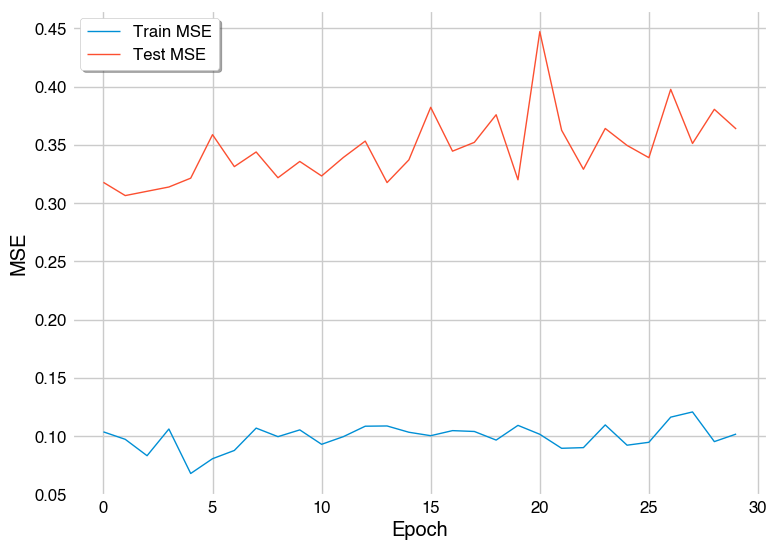

In [8]:
if overwrite or not os.path.exists(best_model_path):
    print(f"Model was saved to {best_model_path}")
    best_model.save(best_model_path)
else:
    print(f"Model file already exists at {best_model_path}. Set 'overwrite=True' to overwrite the file.")
    
utils.plot_mse_over_epochs(History, plots_path, overwrite)

In [9]:
loaded_model = keras.models.load_model(best_model_path)
df_train, rmse_train, r2_train = utils.generate_prediction_df(loaded_model, scaler, X_train, y_train)
df_test, rmse_test, r2_test = utils.generate_prediction_df(loaded_model, scaler, X_test, y_test)

541/541 [==============================] - 0s 331us/step
Root Mean Squared Error: 0.18226283000857665
R2 Score: 0.8976642303252362
136/136 [==============================] - 0s 331us/step
Root Mean Squared Error: 0.34356117976448786
R2 Score: 0.8450052076111488


/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File ANN7_parity_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/whole_data_shuffled_7_feats-V1/ANN7_parity_plot.pdf.


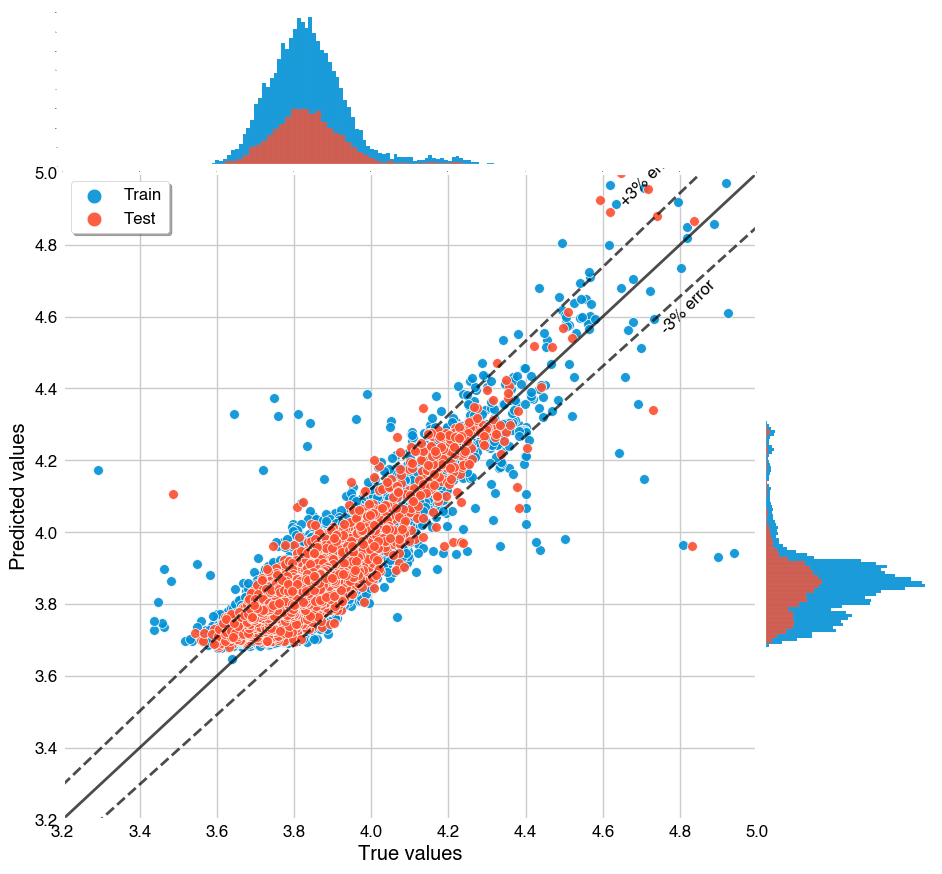

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


File ANN7_residuals_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/whole_data_shuffled_7_feats-V1/ANN7_residuals_plot.pdf.


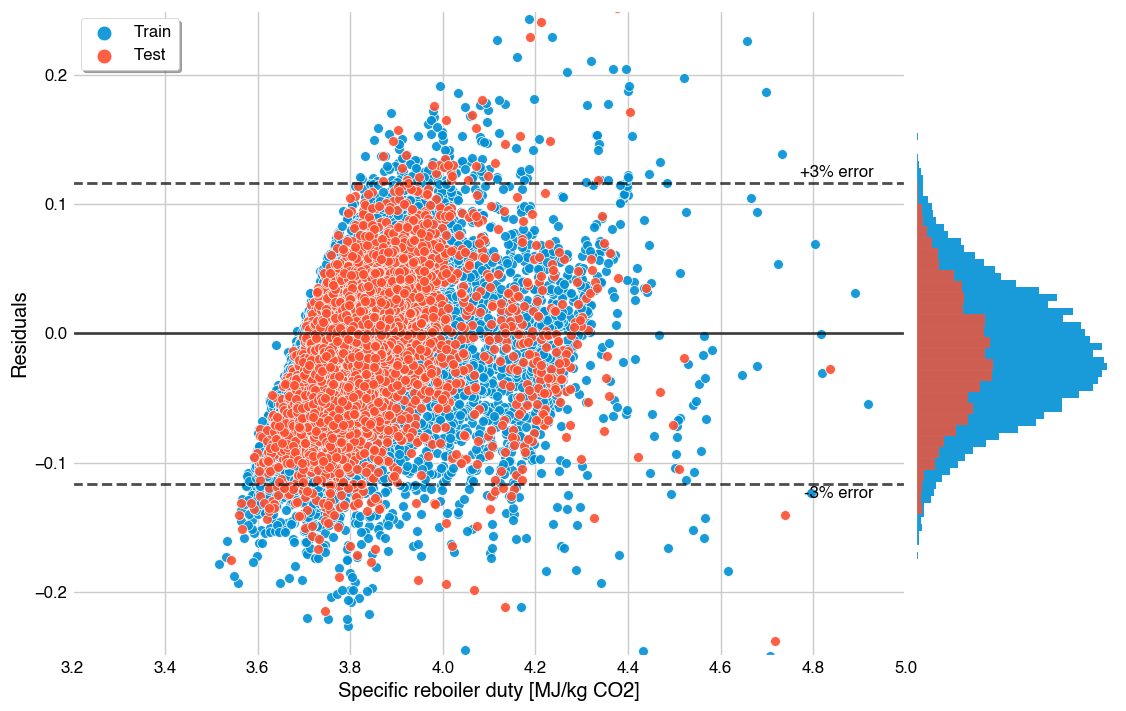

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File ANN7_KDE_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann/whole_data_shuffled_7_feats-V1/ANN7_KDE_plot.pdf.


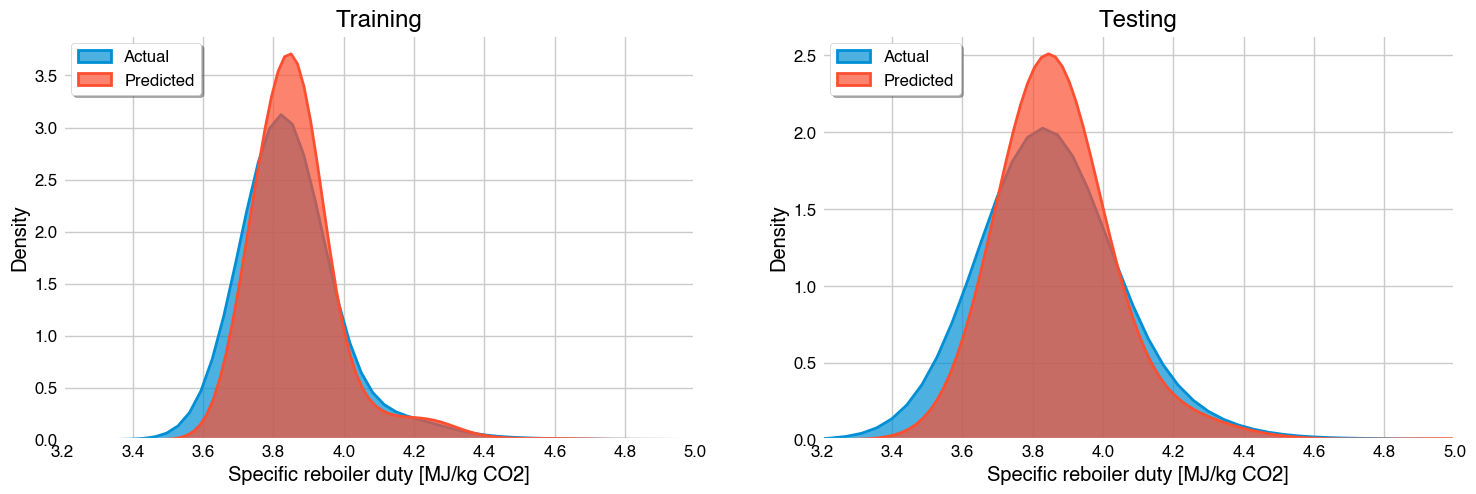

In [13]:
utils.make_evaluation_plots(df_train,
                            df_test,
                            "ANN7",
                            plots_path, 
                            overwrite=False, 
                            limit=[3.2, 5], 
                            error_line=0.03, 
                            res_limit=[-0.25, 0.25], 
                            mean=pd.read_pickle(pkl_path)['SRD'].mean())